# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

>**Tip**: Though it's not a mandate, students can attempt the classroom quizzes to ensure statistical numeric values are calculated correctly in many cases.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
print(df.shape)  # 294478 row  &  5 column

(294478, 5)


**c.** The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [6]:
con = (len(df[df['converted']== 1]))/df.shape[0]
print('Proportion of users converted is',round(con*100),'%')

Proportion of users converted is 12 %


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
tr_not_new = len(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]) + len(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')])
print(tr_not_new)

3893


**f.** Do any of the rows have missing values?

In [8]:
# No

# check Datatypes of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

# We will drop it.
df2 = df
df2.drop(df2.query("group == 'treatment' & landing_page == 'old_page'").index,inplace=True)
df2.drop(df2.query("group == 'control' & landing_page == 'new_page'").index,inplace=True)
df2.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
print(df[df.user_id.duplicated() == True].user_id)

2893    773192
Name: user_id, dtype: int64


**c.** Display the rows for the duplicate **user_id**? 

In [13]:
df[df.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(df2[df2.duplicated(['user_id'])].index)
df2.info()
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id.duplicated() == True]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [16]:
p_population = df2.query('converted == 1').shape[0]/df2.shape[0]
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_con_control = df2.query('(converted == 1) & (group == "control")').shape[0]/df2.query('group == "control"').shape[0]

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_con_treatment = df2.query('(converted == 1) & (group == "treatment")').shape[0]/df2.query('group == "treatment"').shape[0]

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups

obs_diff = p_con_control - p_con_treatment
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Given that the difference in the conversion rate between the control and treatment group is only .15 percent, such a small difference in the conversion rate does not indicate that there is sufficient evidence to suggest that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**$H_{0} : p_{old} \ge p_{new} $**<br><br>
>**$H_{1} : p_{old} < p_{new} $**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [19]:
p_new = df2['converted'].sum() / len(df2)
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [20]:
p_new = df2['converted'].sum() / len(df2)
p_new

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [21]:
df2.groupby(['group', 'landing_page'])['landing_page'].count()

group      landing_page
control    old_page        145274
treatment  new_page        145310
Name: landing_page, dtype: int64

In [22]:
n_new = df2[df2['landing_page'] == 'new_page']['landing_page'].count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2['landing_page'] == 'old_page']['landing_page'].count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [24]:
# Simulate a Sample for the treatment Group

df_treatment = df2.query('group == "treatment"')
sample_new = df_treatment.sample(n_new, replace=True)
new_page_converted = sample_new['converted']
new_page_converted.mean()

0.1182644002477462

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [25]:
# Simulate a Sample for the control Group

df_control = df2.query('group == "control"')
sample_old = df_control.sample(n_old, replace=True)
old_page_converted = sample_old['converted']
old_page_converted.mean()

0.12048267411925052

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.0022182738715043199


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [27]:
# bootstrapping to get the sampling distribution of the conversion differences
control_conv_prob = []
treatment_conv_prob = []
p_diffs = []

# for loops are much slower than numpy functions
for _ in range(10000):
    sample_old2 = df_control.sample(n_old, replace=True)
    sample_new2 = df_treatment.sample(n_new, replace=True)

    control_conversion = sample_old2['converted'].sum() / n_old
    treatment_conversion = sample_new2['converted'].sum() / n_new

# numpy binomial function would generate the distribution given that the null is true
#control_conversion = np.random.binomial(n_old, p_old, 10000) / n_old
#treatment_conversion = np.random.binomial(n_new, p_new, 10000) / n_new
    
    control_conv_prob.append(control_conversion)
    treatment_conv_prob.append(treatment_conversion)
    p_diffs.append(treatment_conversion - control_conversion)
    
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

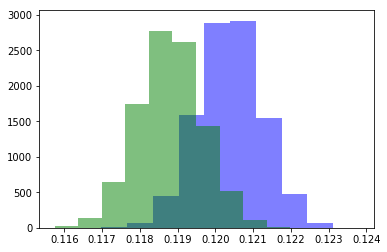

In [28]:
plt.hist(control_conv_prob, alpha=0.5, color='blue')
plt.hist(treatment_conv_prob, alpha=0.5, color='green');

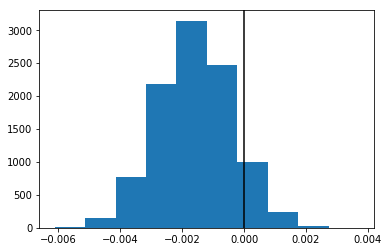

In [30]:
# we simulated a sampling distribution for the conversion difference by bootstrapping
plt.hist(p_diffs);
plt.axvline(x=0, color='black');

In [31]:
# the null hypothesis says the difference is less than or equal to 0
# there is 90% probability that the difference is less than 0 and therefore fitting the H0
stats.percentileofscore(p_diffs, 0)

90.54

In [32]:
(p_diffs < 0).mean()

0.90539999999999998

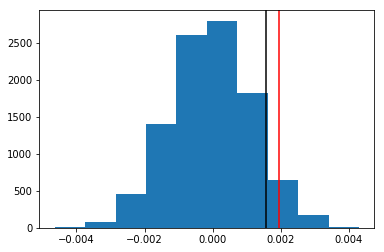

In [33]:
# alternatively, we can simulate the differences under the null, i.e. when the mean difference is 0
# now we can look at how likely it is we would observe our observed difference or a more extreme values in favour of H1, 
# given that the H0 is true, which in our case means difference values higher than the obs_diff
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='black');
plt.axvline(x=np.percentile(null_vals, 95), color='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [34]:
# proportion of the p_diffs greater than the actual difference observed is 50%
# however, if binomial was used to bootstrap, we would have the distribution under the null 
# and then it would be 90%, our p-value
(p_diffs > obs_diff).mean()

0.0051000000000000004

In [35]:
p_value = (null_vals > obs_diff).mean()
p_value

0.088999999999999996

In [36]:
p_value = 1 - stats.percentileofscore(null_vals, obs_diff) / 100
p_value

0.08900000000000008

In [37]:
# we would only be able to reject the null if the observed difference was higher than 0.002
np.percentile(null_vals, 95)

0.0019451308673756156

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**We calculated the p-value. The p-value of 0.9 says that given that the null hypothesis is true, there is 90% probability of observing our conversion difference (or one more extreme in favour of the alternative).
The null therefore cannot be rejected (with a type I error rate of 5% or any other reasonable type I error rate) and we should keep the old page.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [38]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('(converted == 1) and (group == "control")').count()

# number of conversions with the new_page
convert_new = df2.query('(converted == 1) and (group == "treatment")').count()

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').count()

# number of individuals who received new_page
n_new = df2.query('group == "treatment"').count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [40]:
# the order is important and has to follow our hypotheses
counts = [convert_new.iloc[0], convert_old.iloc[0]]
nobs = [n_new.iloc[0], n_old.iloc[0]]

In [42]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(counts, nobs, alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


In [43]:
from scipy.stats import norm
# critical value for 5% type I error level
# we cannot reject the null because the z-score is lower than the critical value
critical_value = norm.ppf(1 - (0.05))
critical_value

1.6448536269514722

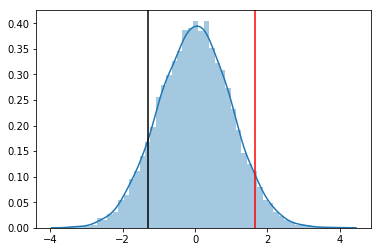

In [44]:
# density plot
g = sns.distplot(np.random.normal(0, 1, 10000))
g.axvline(x=z_score, color='black')
g.axvline(x=critical_value, color='red');

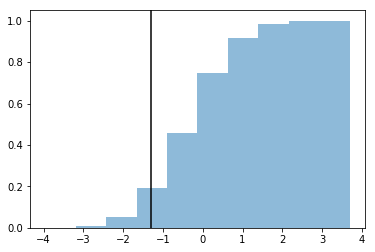

In [45]:
# cdf plot
plt.hist(np.random.normal(0, 1, 10000), density=True, cumulative=True, alpha=0.5)
plt.axvline(x=z_score, color='black');

In [46]:
# z-score is on the 10th percentile of the distribution 
percentile = norm.cdf(z_score)
percentile

0.094941687240975514

In [47]:
# p-value can be calculated as follows from the z-score
p_value = 1 - norm.cdf(z_score)
p_value

0.90505831275902449

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>
****
>Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.


>**The findings of both parts agree.**

>**Z-score is a statistic measured in terms of standard deviations from the mean that can be used to calculate p-value and decide on the hypothesis testing conclusions as is shown above.**

>**The p-value means that we have 90% probability to get the observed difference given that the null is true. It is safe to say that we do not have evidence that the new page leads to more conversions and we should stick to the old page**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic regression should be used for this case**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [48]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [56]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [57]:
results.summary()

AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**The p-value associated with ab_page is 0.19. The null cannot be rejected because 0.19 is above our Type I error threshold of 0.05.
The negative coefficient of ab_page is therefore insignificant, so we cannot say that the new page has any effect on the conversion rate.
The old page should therefore be kept because the new page did not prove to have higher conversions.
This conclusion is the same like in the previous part, however the p-value differs from the value found in Part II due to different hypotheses being tested in the two parts.
In this case, we are doing a two-tailed test, so the alternative is that the new page has a different conversion rate than the old page (in whichever direction). So if the new page actually performs worse than the old page, it would still fit the alternative hypothesis and this is why the p-value decreased (due to our negative observed difference).
This is the case because the null of the logistic regression is that the new page has no impact on conversions, i.e. that the probability of conversion is the same with the old page and the new page. The alternative for this case is that the probabilities are different.
On the other hand, in the previous part we did one-tailed test, in which the alternative was that the new page has higher conversions.**

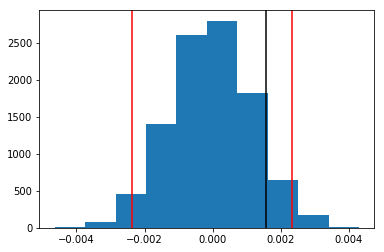

In [58]:
# to make a comparison to the previous part, having a two-tailed test there would mean that we would reject the null 
# if the observed conversion difference is either lower than -0.0023 or higher than 0.0023
# we see that we are definitely somewhat closer to the rejection region (i.e. there is also a lower p-value) in this case 
# than we were in the one-tailed case
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='black')
plt.axvline(x=np.percentile(null_vals, 2.5), color='red')
plt.axvline(x=np.percentile(null_vals, 97.5), color='red');

In [59]:
print('2.5th percentile:', np.percentile(null_vals, 2.5))
print('97.5th percentile:', np.percentile(null_vals, 97.5))

2.5th percentile: -0.00236952004595
97.5th percentile: 0.00232269199247


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**We only look at the effect of the new page on the conversion rate right now. However, in reality many other factors probably also have influence on whether or not the user converts, such as when they are existing customers and might suffer from change aversion, or that they might convert due to other changes happening on the site or for some other reasons than being presented with the new page, for example due to their specific customer characteristics.**

>**The disadvantage to adding more terms to the regression is for example the multiple comparison problem, which means that the more metrics are evaluated, the more likely it is to observe significant differences just by chance. The more inferences are made, the more likely erroneous inferences are to occur.
Adding more terms will always improve the model regardless of whether the added term adds a significant value. Adding many independent variables can potentially lead to overfitting, where our training data is exactly modeled, but the estimates do not work for new unknown data. The estimation can for example also suffer from multicollinearity, which occurs when we have highly correlated predictors.
Another potential issues to consider are Simpson's paradox or confounding variables.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [60]:
# Read the countries.csv
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [61]:
# Join with the df2 dataframe
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [62]:
# Create the necessary dummy variables
dum_countries = pd.get_dummies(df_new['country'])
df4 = dum_countries.join(df_new, how='inner')
df4.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,0,1,0,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,0,1,0,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [63]:
log_mod1 = sm.Logit(df4['converted'], df4[['intercept', 'UK', 'CA']])
results = log_mod1.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [64]:
# Fit your model, and summarize the results
log_mod2 = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'UK', 'CA']])
results = log_mod2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

In [65]:
UK_newpage = df4['ab_page'] * df4['UK']
df4['UK_newpage'] = UK_newpage

In [66]:
CA_newpage = df4['ab_page'] * df4['CA']
df4['CA_newpage'] = CA_newpage
df4.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page,UK_newpage,CA_newpage
user_id,,,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,0,1,0,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,0,1,0,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [67]:
### Fit Your Linear Model And Obtain the Results
log_mod3 = sm.Logit(df4['converted'], df4[['intercept', 'UK', 'CA', 'UK_newpage', 'CA_newpage']])
results = log_mod3.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

In [68]:
log_mod4 = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage']])
results = log_mod4.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


AttributeError: module 'scipy.stats' has no attribute 'chisqprob'

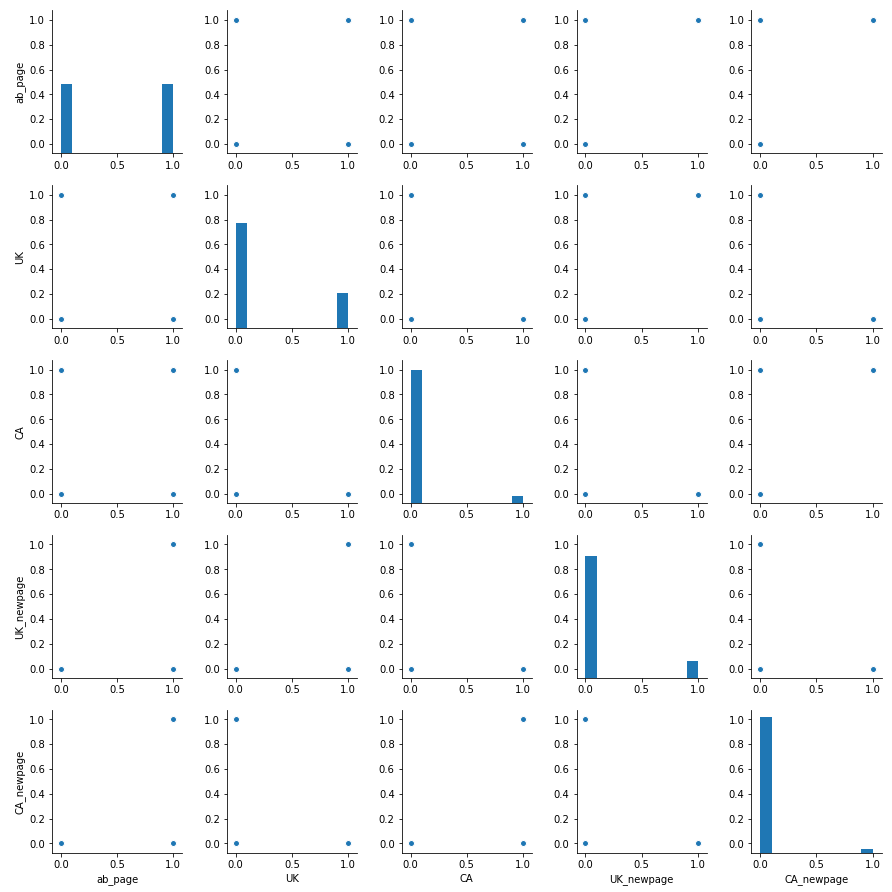

In [69]:
# pairwise correlations
# these are normally a good way to check for multicollinearity, however since we only have categorical variables 
# (which is also the probable reason why we cannot fit any good model), we do not learn much about their relationship
sns.pairplot(df4[['ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage']]);
# we learn that number of customer with the new page is the same as with the old page
# we learn that UK customers with new page convert less than UK customers in general
# UK customers convert high above our overall conversion rate of around 12%

>**- We used several ways to test whether the introduction of the new page increases conversions.
The conclusion in all of them is that the new page did not prove to be better than the old page and we do not <br>- have the evidence to switch to the new page.
We failed to find a model that would be good at predicting conversions based on the data we have available**

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])